In [2]:
import tensorflow as tf
#import tensorflow.contrib.learn.python.learn as learn
import tflearn 
import scipy as sp
from scipy.signal import find_peaks_cwt as peakFinder
import numpy as np 
import matplotlib.pyplot as plt
from random import shuffle, randint
from sklearn.utils import shuffle as mutualShuf
import pandas as pd
import sklearn
import datetime
%matplotlib inline

# Import and process data

In [3]:
def importPickle(fileLocation): # File location is ./inData/6060DataFrame.pkl
    """
    Imports Daniel Wilson's datafile and respectively returns a matrix of class 
    (whether patient is healthy or unhealthy) data, and a matrix of coil data.
    """
    # Import dataframe
    path60  = fileLocation
    df60 = pd.read_pickle(path60)
    # Separate pandas dataframe into classification and data arrays
    classData = df60["Classification"].as_matrix()
    coilData = df60["Coil Data"].as_matrix()
    
    return classData, coilData

def splitData(coilData, classData):
    """
    Split data into healthy and ill types.
    """
    illData = []
    healthData = []
    
    for index, item in enumerate(classData):
        if item == 1:
            illData.append(coilData[index])
        if item == 0:
            healthData.append(coilData[index])
            
    return illData, healthData

def flattenArr(arr):
    """
    Flatten an array with our input shape.
    """
    for i in np.arange(0,len(arr),1):
        arr[i] = np.hstack(arr[i])
    return np.hstack(arr)

classData, coilData = importPickle("./inData/6060DataFrame.pkl")
# Replace outlier reading 138 (far far too big!)
classData[138] = classData[137]
coilData[138] = coilData[137]

illData, healthData = splitData(coilData, classData)
illUnseen = illData[:100]
healthUnseen = healthData[:100]
illData = illData[100:]
healthData = healthData[100:]

# Flatten arrays...
illUnseen = flattenArr(illUnseen)
healthUnseen = flattenArr(healthUnseen)
illData = flattenArr(illData)
healthData = flattenArr(healthData)

344


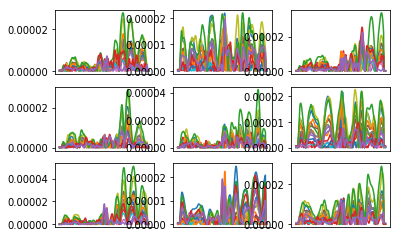

In [4]:
# Various plots...
r = randint(0,390)
print(r)
fig, ax = plt.subplots(3,3)
for i in np.arange(0,ax.shape[0],1):
    for j in np.arange(0,ax.shape[1],1):
        r = r+1
        for k in np.arange(0,15):
            ax[i,j].plot(np.abs(coilData[r][k, 0:2000]))
            ax[i,j].set_xticks([])

In [5]:
def findAbove(arr, threshold):
    """
    Return indices for values above threshhold in array, arr. Keep only first items in sequence.
    """
    inlst = []
    for index, item in enumerate(arr):
        if item >= threshold:
            inlst.append(index)
            
    return inlst

def getSamples(arr, peakArr, buffer):
    """
    Get samples for array arr with buffer each side of peak indices, in peakArr.
    """
    sampledData = []
    for i in peakArr:
        if len(arr[i-buffer: i+buffer]) == buffer*2: # Check that all samples are same size
            sampledData.append(arr[i-buffer: i+buffer])
        
    return sampledData

def shuffle2Lst(list1, list2):
    """ 
    Shuffle two lists in similar ways.
    """
    list1_shuf = []
    list2_shuf = []
    index_shuf = np.arange(len(list1))
    shuffle(index_shuf)
    for i in index_shuf:
        list1_shuf.append(list1[i])
        list2_shuf.append(list2[i])
    return list1_shuf, list2_shuf

def processClassData(classData):
    """
    Process classData.
    
    Returns a one-hot array of shape [len(classData), 2].
    """
    # Convert label data to one-hot array
          
    classDataOH = np.zeros((len(classData),2))
    classDataOH[np.arange(len(classData)), classData] = 1
    
    return classDataOH

def visualiseData(ecgData, classData, gridSize, axis):
    """
    Plot labelled example data in a gridSize*gridSize grid.
    """
    fig, ax = plt.subplots(gridSize, gridSize)
    plt.suptitle("Labelled example data")
    r = randint(0,len(classData)-16)
    k = 0
    for i in np.arange(0,gridSize,1):
        for j in np.arange(0,gridSize,1):
            k = k + 1
            ax[i,j].plot(ecgData[r+k])
            if axis == False:
                ax[i,j].axis("off")
            ax[i,j].annotate(classData[r+k], xy=(0, 0), xycoords='axes points',\
                        size=10, ha='left', va='top')

def undiff(ecgData, buffer):
    """
    Reverse the differentiation done earlier through np.cumsum.
    """
    ecgData = np.reshape(ecgData, (ecgData.shape[0], buffer*2))
    for i in np.arange(0,ecgData.shape[0],1):
        ecgData[i] = np.cumsum(ecgData[i])
    ecgData = np.reshape(ecgData, (ecgData.shape[0], buffer*2, 1))
    return ecgData            

def chunkify(lst,n):
    """ Chunk a list into n chunks of approximately equal size """
    return [ lst[i::n] for i in range(n) ]

def functionTown(illArr, healthArr, illThreshold, healthThreshold, skip, buffer, shuffle):
    """
    Return the processed ecgData and the classData (one-hot). Also return arrays of ill and healthy ppts.
    If shuffle is true, shuffle data.
    """
    illPeakArr = findAbove(np.abs(illArr), illThreshold)
    illSampled = getSamples(illArr, illPeakArr, buffer)
    healthPeakArr = findAbove(np.abs(healthArr), healthThreshold)
    healthSampled = getSamples(healthArr, healthPeakArr, buffer)

    chunkyI = chunkify(illSampled, 10000)
    chunkyH = chunkify(healthSampled , 10000)
    avgI = []
    avgH = []
    
    for i in np.arange(0,len(chunkyI),1):
        avgI.append(np.mean(chunkyI[i], axis=0))
        
    for i in np.arange(0,len(chunkyH),1):
        avgH.append(np.mean(chunkyH[i], axis=0))
    
    illSampled = np.array(avgI)
    healthSampled = np.array(avgH)
    
    print("Total ill samples", len(illPeakArr), ". Compressed to", illSampled.shape)
    print("Total healthy samples", len(healthPeakArr), ". Compressed to", healthSampled.shape)
    
    classData = []
    for i in np.arange(0, len(illSampled), 1):
        classData.append(1)
    for i in np.arange(0, len(healthSampled), 1):
        classData.append(0)
    ecgData = np.concatenate((illSampled, healthSampled), axis=0)
    
    if shuffle == True:
        classData, ecgData = mutualShuf(np.array(classData), ecgData, random_state=0)    
        
    classDataOH = processClassData(classData)
    
    ecgData = np.reshape(np.concatenate(ecgData, axis=0), [len(ecgData), buffer*2, 1])
    
    return ecgData, classDataOH, classData
    
buffer = 300
healthThreshold = 0.000003
illThreshold = 0.000003
skip = 1

ecgData, classDataOH, classData = functionTown(illData, healthData, illThreshold, healthThreshold, skip, buffer, True)
# Reintegrate the found values...
ecgData = undiff(ecgData, buffer)
# Split ecgData into k sets so we can perform k-fold cross validation:
k = 1
kfoldData = np.array_split(ecgData, k)
kfoldLabelsOH = np.array_split(classDataOH, k)
kfoldLabels = np.array_split(classData, k)

# Get the unseen data:
unseenData, unseenClassOH, unseenClass = functionTown(illUnseen, healthUnseen, illThreshold, \
                                                      healthThreshold, skip, buffer, True)
unseenData = undiff(unseenData, buffer)
iUnseen, hUnseen = splitData(unseenData, unseenClass)
unseenHL = np.tile([1,0], (len(hUnseen), 1))
unseenIL = np.tile([0,1], (len(iUnseen), 1))

Total ill samples 1180990 . Compressed to (10000, 600)
Total healthy samples 1685169 . Compressed to (10000, 600)
Total ill samples 1205739 . Compressed to (10000, 600)
Total healthy samples 1625984 . Compressed to (10000, 600)


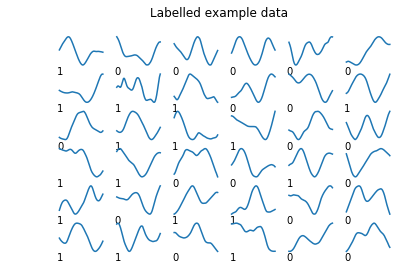

In [6]:
visualiseData(ecgData, classData, 6, False)
#plt.savefig("./outData/figures/messy_mcg_example300buf.pdf")

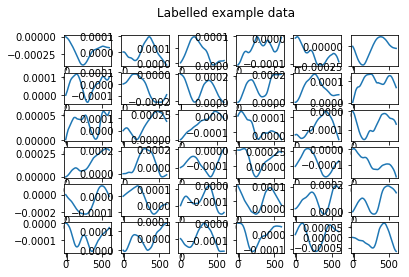

In [7]:
visualiseData(unseenData, unseenClass, 6, True)

# Neural Network

In [8]:
healthEval = []
illEval = []
spec = []
sens = []
unseenSpec = []
unseenSens = []
unseenAvg = []

In [9]:
if k != 1:
    for i in np.arange(0,k,1):
        sess = tf.InteractiveSession()
        tf.reset_default_graph()
        tflearn.initializations.normal()

        # Input layer:
        net = tflearn.layers.core.input_data(shape=[None, buffer*2, 1])

        # First layer:
        net = tflearn.layers.conv.conv_1d(net, 64, 10, activation="leaky_relu")
        net = tflearn.layers.conv.max_pool_1d(net, 2)

        # Second layer:
        net = tflearn.layers.conv.conv_1d(net, 128, 5, activation="leaky_relu")
        net = tflearn.layers.conv.max_pool_1d(net, 2)

        # Fully connected layer 1:
        net = tflearn.layers.core.fully_connected(net, 1024, regularizer="L2", weight_decay=0.001, activation="leaky_relu")

        # Dropout layer:
        net = tflearn.layers.core.dropout(net, keep_prob=0.5)

        # Output layer:
        net = tflearn.layers.core.fully_connected(net, 2, activation="softmax")

        net = tflearn.layers.estimator.regression(net, optimizer='adam', loss='categorical_crossentropy',\
                                 learning_rate=0.001)

        model = tflearn.DNN(net, tensorboard_verbose=3)
        dummyData = np.reshape(np.concatenate(kfoldData[:i] + kfoldData[i+1:], axis=0), [-1, buffer*2, 1])
        dummyLabels = np.reshape(np.concatenate(kfoldLabelsOH[:i] + kfoldLabelsOH[i+1:], axis=0), [-1, 2])
        model.fit(dummyData, dummyLabels, n_epoch=3, show_metric=True)

        illTest = []
        healthTest = []
        for index, item in enumerate(kfoldLabels[i]):
            if item == 1:
                illTest.append(kfoldData[i][index])
            if item == 0:
                healthTest.append(kfoldData[i][index])

        healthLabel = np.tile([1,0], (len(healthTest), 1))
        illLabel = np.tile([0,1], (len(illTest), 1))

        sens.append(model.evaluate(np.array(healthTest), healthLabel))
        spec.append(model.evaluate(np.array(illTest), illLabel))
    
        unseenAvg.append(model.evaluate(unseenData, unseenClassOH))
        unseenSpec.append(model.evaluate(np.array(iUnseen), unseenIL))
        unseenSens.append(model.evaluate(np.array(hUnseen), unseenHL))

if k == 1:
    sess = tf.InteractiveSession()
    tf.reset_default_graph()
    tflearn.initializations.normal()

    # Input layer:
    net = tflearn.layers.core.input_data(shape=[None, buffer*2, 1])

    # First layer:
    net = tflearn.layers.conv.conv_1d(net, 64, 5, activation="leaky_relu")
    net = tflearn.layers.conv.max_pool_1d(net, 2)

    # Second layer:
    net = tflearn.layers.conv.conv_1d(net, 128, 5, activation="leaky_relu")
    net = tflearn.layers.conv.max_pool_1d(net, 2)

    # Fully connected layer 1:
    net = tflearn.layers.core.fully_connected(net, 1024, regularizer="L2", weight_decay=0.001, activation="leaky_relu")

    # Dropout layer:
    net = tflearn.layers.core.dropout(net, keep_prob=0.5)

    # Output layer:
    net = tflearn.layers.core.fully_connected(net, 2, activation="softmax")

    net = tflearn.layers.estimator.regression(net, optimizer='adam', loss='categorical_crossentropy',\
                             learning_rate=0.0001)

    model = tflearn.DNN(net, tensorboard_verbose=3)
    model.fit(ecgData, classDataOH, n_epoch=3, validation_set=0.1, show_metric=True)

Training Step: 845  | total loss: 0.69311 | time: 454.340s
| Adam | epoch: 003 | loss: 0.69311 - acc: 0.5129 -- iter: 17984/18000
Training Step: 846  | total loss: 0.69311 | time: 460.211s
| Adam | epoch: 003 | loss: 0.69311 - acc: 0.5179 | val_loss: 0.69316 - val_acc: 0.4960 -- iter: 18000/18000
--


In [ ]:
if k != 1:
    print("Specificity:", spec, "\nAvg:", np.mean(spec), "\nSensitivity:", sens, "\nAvg:", np.mean(sens),\
         "\nUnseen Spec:", unseenSpec, "\nUnseen Sens:", unseenSens, "\nUnseen Avg:", unseenAvg)

else:
    print(model.evaluate(unseenData, unseenClassOH),"\n",\
    model.evaluate(np.array(iUnseen), unseenIL),"\n",\
    model.evaluate(np.array(hUnseen), unseenHL))

In [71]:
(len(iUnseen))/(len(hUnseen)+len(iUnseen))

0.2400594574507618

In [38]:
# Save model?
#now = datetime.datetime.now()
#model.save("./outData/models/0-92-messyMCG_"+now.isoformat()+"_.tflearn")

INFO:tensorflow:././outData/models/0-92-messyMCG_2017-02-22T18:25:59.861381_.tflearn is not in all_model_checkpoint_paths. Manually adding it.
